<a href="https://colab.research.google.com/github/florivz/DDM-Project-WS24-25/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/florivz/DDM-Project-WS24-25.git

Cloning into 'DDM-Project-WS24-25'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 20), reused 16 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 31.98 MiB | 6.02 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (11/11), done.


In [2]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from google.colab import userdata
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

# Loading the Data

In [3]:
pkl_path = 'DDM-Project-WS24-25/pkl/'

In [4]:
gdp_data = pd.read_pickle(pkl_path + "gdp.pickle")
df_pattern = pd.read_pickle(pkl_path + "naics_pattern.pickle")
df_occupation_1 = pd.read_pickle(pkl_path + "naics_occupation_part1.pickle")
df_occupation_2 = pd.read_pickle(pkl_path + "naics_occupation_part2.pickle")
df_occupation_3 = pd.read_pickle(pkl_path + "naics_occupation_part3.pickle")
df_county = pd.read_pickle(pkl_path + "county.pickle")
df_state = pd.read_pickle(pkl_path + 'state.pickle')

# Transforming the data

In [5]:
# def add_zeros(code):
#     if len(code) == 3:
#         return '00' + code
#     elif len(code) == 4:
#         return '0' + code
#     elif len(code) == 1:
#         return '0000' + code
#     return code

In [6]:
# Filling 0 to get same length for all FIPS
# df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)
# unique_lengths = df_pattern['FIPS'].apply(len).unique()
# unique_lengths

# df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

In [7]:
# Merging Occupation Datasets
df_occupation = pd.concat([df_occupation_1, df_occupation_2, df_occupation_3], ignore_index=True)
df_occupation.head(5)

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


In [8]:
# Imputing missing GDP data based on the average of adjacent years
# columns_to_impute = ['2017', '2018', '2019', '2020', '2021', '2022']

# def impute_missing_data(row):
#     for col in columns_to_impute:
#         if pd.isna(row[col]):
#             adjacent_years = [c for c in columns_to_impute if c != col]
#             values = [row[y] for y in adjacent_years if not pd.isna(row[y])]
#             row[col] = np.mean(values) if values else np.nan
#     return row

# gdp_data = gdp_data.apply(impute_missing_data, axis=1)

In [9]:
# Calculating GDP growth rate
gdp_data['GDP_growth_rate'] = (gdp_data['2022'] / gdp_data['2021']) * 100
gdp_data = gdp_data[(gdp_data != 0.0).all(axis=1)]
gdp_data = gdp_data.sort_values(by='GDP_growth_rate', ascending=False)
gdp_data.head()

,FIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,2017,2018,2019,2020,2021,2022,GDP_growth_rate
14594,13053,"Chattahoochee, GA",5,CAGDP9,25,"311-316,322-326",Nondurable goods manufacturing,Thousands of chained 2017 dollars,117.0,76.0,601.0,856.0,18.0,2001.0,11116.666667
92857,48319,"Mason, TX",6,CAGDP9,6,21,"Mining, quarrying, and oil and gas extraction",Thousands of chained 2017 dollars,15741.0,11470.0,6203.0,192.0,7.0,318.0,4542.857143
83439,46093,"Meade, SD",4,CAGDP9,6,21,"Mining, quarrying, and oil and gas extraction",Thousands of chained 2017 dollars,191.0,151.0,118.0,212.0,3.0,114.0,3800.000000
16866,13187,"Lumpkin, GA",5,CAGDP9,3,11,"Agriculture, forestry, fishing and hunting",Thousands of chained 2017 dollars,6249.0,3704.0,596.0,697.0,621.0,15307.0,2464.895330
18974,13313,"Whitfield, GA",5,CAGDP9,3,11,"Agriculture, forestry, fishing and hunting",Thousands of chained 2017 dollars,36393.0,35672.0,9588.0,2785.0,2936.0,69144.0,2355.040872


In [10]:
# Keeping only the necessary columns

# GDP
df_gdp_filtered = gdp_data.drop(gdp_data[['TableName', 'LineCode', 'Unit', 'Region', '2017', '2018', '2019', '2020', '2021', 'GeoName', 'IndustryClassification', 'Description']], axis=1)
df_gdp_filtered = df_gdp_filtered.rename(columns={'2022': 'current_gdp'})

df_gdp_filtered['FIPS'] = df_gdp_filtered['FIPS'].astype(str)
df_gdp_filtered = df_gdp_filtered[df_gdp_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers --> need it on county level

# Naics Pattern
df_pattern_filtered = df_pattern.drop(columns=['emp_nf', 'qp1_nf', 'qp1', 'ap_nf',
       'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4', 'naics_2', 'State_GEOID',	'County_GEOID'])
df_pattern_filtered = df_pattern_filtered.rename(columns={'DESCRIPTION': 'naics_description'})

df_pattern_filtered['FIPS'] = df_pattern_filtered['FIPS'].astype(str)
df_pattern_filtered = df_pattern_filtered[df_pattern_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers

# Naics Occupation
df_occupation_filtered = df_occupation.drop(columns=['State_GEOID', 'NAICS_TITLE', 'emp_total_county_naics', 'state_name'])

df_occupation_filtered['FIPS'] = df_occupation_filtered['FIPS'].astype(str)
df_occupation_filtered = df_occupation_filtered[df_occupation_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers

In [11]:
# # Define the relevant NAICS code prefixes as strings
# relevant_naics_prefixes = ['21', '23', '31', '32', '33']  # Sectors for Mining, Construction, Manufacturing

# # Convert relevant prefixes to a tuple for startswith
# relevant_naics_prefixes = tuple(relevant_naics_prefixes)

# # Filter df_gdp_filtered
# df_gdp_filtered = df_gdp_filtered[
#     df_gdp_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

# # Filter df_pattern_filtered
# df_pattern_filtered = df_pattern_filtered[
#     df_pattern_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

# # Filter df_occupation_filtered
# df_occupation_filtered = df_occupation_filtered[
#     df_occupation_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

In [12]:
# Merge the result with df_occupation_filtered on FIPS and naics
df_naics = df_pattern_filtered.merge(
    df_occupation_filtered,
    on=['FIPS', 'naics'],
    how='left',
)

In [13]:
df_naics.head()

,FIPS,naics,naics_description,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2131,Support Activities for Mining,54,7136,5,49-9041,Industrial Machinery Mechanics,1.672731
1,10001,2131,Support Activities for Mining,54,7136,5,51-4121,"Welders, Cutters, Solderers, and Brazers",0.650311
2,10001,2131,Support Activities for Mining,54,7136,5,49-3042,"Mobile Heavy Equipment Mechanics, Except Engines",0.337553
3,10001,2131,Support Activities for Mining,54,7136,5,49-3031,Bus and Truck Mechanics and Diesel Engine Spec...,0.295242
4,10001,2131,Support Activities for Mining,54,7136,5,49-9071,"Maintenance and Repair Workers, General",0.271479


In [14]:
# Group by 'FIPS' and 'naics', then sum the specified columns
df_naics_agg = df_naics.groupby(['naics', 'naics_description']).agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
}).reset_index()

df_naics_agg.head()

,naics,naics_description,ap,est,emp
0,1133,Logging,14144703,44479,273558
1,2111,Oil and Gas Extraction,160920430,65731,1086954
2,2121,Coal Mining,28820400,5325,338280
3,2122,Metal Ore Mining,47106670,2210,468182
4,2123,Nonmetallic Mineral Mining and Quarrying,88577161,69455,1183116


In [15]:
# Generate random values for each NAICS and assign them to each entry in the group
np.random.seed(1)

random_values = {naics: np.random.randint(0, 11) for naics in df_naics_agg['naics'].unique()}
df_naics_agg['tool_consumption'] = df_naics_agg['naics'].map(random_values)
df_naics_agg.sort_values(by='emp', ascending=False).head(10)

,naics,naics_description,ap,est,emp,tool_consumption
64,5613,Employment Services,17594424274,2575773,316290486,6
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9
13,2382,Building Equipment Contractors,2471259455,3208151,36373647,2
35,3330A1,"3331, 3332, 3334, 3339",1511893370,362952,20220626,3
24,3261,Plastics Product Manufacturing,1112538162,281892,19934743,6
43,3363,Motor Vehicle Parts Manufacturing,1107920522,134988,19280562,1
12,2381,"Foundation, Structure, and Building Exterior C...",1123358347,2190290,18616472,5
65,5617,Services to Buildings and Dwellings,641252104,1986470,17649729,9
67,8111,Automotive Repair and Maintenance,613043765,2579928,14193850,7
9,2371,Utility System Construction,988834457,381603,12313454,9


In [16]:
df_gdp_agg = df_gdp_filtered.groupby('FIPS').agg({
    'current_gdp': 'sum',
    'GDP_growth_rate': 'sum'
}).reset_index()
df_gdp_agg.head()

,FIPS,current_gdp,GDP_growth_rate
0,10000,355577213.0,3547.300053
1,10001,22652836.0,2057.552230
2,10003,243477316.0,2962.917645
3,10005,43727204.0,2344.828798
4,11000,574989171.0,3328.926192


# Ranking Industries

In [17]:
df_rank = df_naics_agg.copy()

for column in df_rank.columns[df_rank.columns.get_loc('ap'):]:
    rank_column_name = f'rank_{column}'
    df_rank[rank_column_name] = df_rank[column].rank(method='min', ascending=False).astype(int)

df_rank.sort_values(by='rank_emp').head()

,naics,naics_description,ap,est,emp,tool_consumption,rank_ap,rank_est,rank_emp,rank_tool_consumption
64,5613,Employment Services,17594424274,2575773,316290486,6,1,4,1,33
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9,2,2,2,5
13,2382,Building Equipment Contractors,2471259455,3208151,36373647,2,3,1,3,53
35,3330A1,"3331, 3332, 3334, 3339",1511893370,362952,20220626,3,4,14,4,48
24,3261,Plastics Product Manufacturing,1112538162,281892,19934743,6,6,17,5,33


In [18]:
weights = {
    'rank_tool_consumption': 0.5,
    'rank_emp': 0.2,
    'rank_ap': 0.1,
    'rank_est': 0.2
}

In [19]:
# calculate the weighted sum
df_rank['Weighted_Sum'] = (df_rank['rank_tool_consumption'] * weights['rank_tool_consumption'] +
                          df_rank['rank_emp'] * weights['rank_emp'] +
                          df_rank['rank_ap'] * weights['rank_ap'] +
                          df_rank['rank_est'] * weights['rank_est'])
df_rank = df_rank.sort_values(by='Weighted_Sum', ascending=True)
# imputing 3371, 3372 with actual description
df_rank['naics_description'] = df_rank['naics_description'].str.replace('3371, 3372', 'Furniture and Related Product Manufacturing', regex=False)
df_rank.head(20)

,naics,naics_description,ap,est,emp,tool_consumption,rank_ap,rank_est,rank_emp,rank_tool_consumption,Weighted_Sum
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9,2,2,2,5,3.5
65,5617,Services to Buildings and Dwellings,641252104,1986470,17649729,9,16,6,8,5,6.9
9,2371,Utility System Construction,988834457,381603,12313454,9,8,13,10,5,7.9
49,3399,Other Miscellaneous Manufacturing,453204190,472189,7837580,10,21,11,19,1,8.6
33,3327,"Machine Shops; Turned Product; and Screw, Nut,...",611343199,636266,10365797,8,18,9,14,17,14.9
44,3364,Aerospace Product and Parts Manufacturing,946714787,35629,9811934,9,9,43,16,5,15.2
67,8111,Automotive Repair and Maintenance,613043765,2579928,14193850,7,17,3,9,23,15.6
37,3335,Metalworking Machinery Manufacturing,235282422,150709,3546341,9,31,23,30,5,16.2
47,3370A1,Furniture and Related Product Manufacturing,385685233,331463,7914077,8,24,15,18,17,17.5
64,5613,Employment Services,17594424274,2575773,316290486,6,1,4,1,33,17.6


In [20]:
top_industries = np.array(df_rank['naics'].iloc[0:5])
top_industries

array(['5413', '5617', '2371', '3399', '3327'], dtype=object)

In [21]:
df_top_industries = df_naics[df_naics['naics'].isin(top_industries)].reset_index(drop=True)
df_top_industries.head()

,FIPS,naics,naics_description,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2371,Utility System Construction,210,12195,12,51-4121,"Welders, Cutters, Solderers, and Brazers",4.097994
1,10001,2371,Utility System Construction,210,12195,12,49-3042,"Mobile Heavy Equipment Mechanics, Except Engines",3.131093
2,10001,2371,Utility System Construction,210,12195,12,47-5022,Excavating and Loading Machine and Dragline Op...,1.459150
3,10001,2371,Utility System Construction,210,12195,12,49-9071,"Maintenance and Repair Workers, General",1.113063
4,10001,2371,Utility System Construction,210,12195,12,47-2221,Structural Iron and Steel Workers,0.712586


# Ranking Occupations

In [22]:
# Generate random values for each NAICS and assign them to each entry in the group
random_values = {naics: np.random.randint(0, 11) for naics in df_occupation_filtered['naics'].unique()}
df_occupation_filtered['tool_consumption_occ'] = df_occupation_filtered['naics'].map(random_values)

In [23]:
occupation_result = df_occupation_filtered.groupby(['OCC_CODE','OCC_TITLE', 'tool_consumption_occ']).agg(
    emp_occ_sum=('emp_occupation', 'sum'),             # Sum of values in the 'emp' column
    unique_FIPS=('FIPS', 'nunique'),    # Count of unique values in the 'FIPS' column
).sort_values(by='emp_occ_sum', ascending=False).reset_index()

# Display the first 20 rows
occupation_result.head(20)

,OCC_CODE,OCC_TITLE,tool_consumption_occ,emp_occ_sum,unique_FIPS
0,49-3023,Automotive Service Technicians and Mechanics,5,250666.887500,2725
1,51-4041,Machinists,7,147662.089603,2142
2,49-9071,"Maintenance and Repair Workers, General",4,125218.379802,1777
3,17-2141,Mechanical Engineers,7,111098.315988,2264
4,51-4072,"Molding, Coremaking, and Casting Machine Sette...",10,105306.666658,1221
5,49-3021,Automotive Body and Related Repairers,5,103113.463321,2725
6,51-4121,"Welders, Cutters, Solderers, and Brazers",9,95257.256972,1296
7,51-4121,"Welders, Cutters, Solderers, and Brazers",7,89060.342593,2270
8,17-2112,Industrial Engineers,7,67937.149526,2233
9,49-9041,Industrial Machinery Mechanics,6,64382.993897,1764


In [24]:
# Create a copy of the DataFrame
occupation_result_copy = occupation_result.copy()

# Calculate rank for all columns starting from 'tool_consumption', with equal values having the same rank
for column in occupation_result_copy.columns[occupation_result_copy.columns.get_loc('tool_consumption_occ'):]:
    rank_column_name = f'rank_{column}'
    occupation_result_copy[rank_column_name] = occupation_result_copy[column].rank(method='min', ascending=False).astype(int)

# Display the first few rows of the copied data
occupation_result_copy.head()

,OCC_CODE,OCC_TITLE,tool_consumption_occ,emp_occ_sum,unique_FIPS,rank_tool_consumption_occ,rank_emp_occ_sum,rank_unique_FIPS
0,49-3023,Automotive Service Technicians and Mechanics,5,250666.887500,2725,281,1,12
1,51-4041,Machinists,7,147662.089603,2142,168,2,53
2,49-9071,"Maintenance and Repair Workers, General",4,125218.379802,1777,324,3,91
3,17-2141,Mechanical Engineers,7,111098.315988,2264,168,4,44
4,51-4072,"Molding, Coremaking, and Casting Machine Sette...",10,105306.666658,1221,1,5,232


In [25]:
weights = {
    'rank_tool_consumption_occ': 0.5,   # Weight for the ranking column 'tool_consumption'
    'rank_emp_occ_sum': 0.3,            # Weight for the ranking column 'emp_sum'
    'rank_unique_FIPS': 0.2,         # Weight for the ranking column 'unique_FIPS'
}


In [26]:
# calculate the weighted sum
occupation_result_copy['Weighted_Sum_Occ'] = (occupation_result_copy['rank_tool_consumption_occ'] * weights['rank_tool_consumption_occ'] +
                          occupation_result_copy['rank_emp_occ_sum'] * weights['rank_emp_occ_sum'] +
                          occupation_result_copy['rank_unique_FIPS'] * weights['rank_unique_FIPS']
                          ) # Display the first few rows
occupation_sorted = occupation_result_copy.sort_values(by='Weighted_Sum_Occ', ascending=True)

In [27]:
top_occ = occupation_sorted[:5]['OCC_CODE'].tolist()
top_occ

['49-9071', '49-9041', '17-2112', '51-4031', '51-4072']

In [28]:
df_top_occupations = df_naics[df_naics['OCC_CODE'].isin(top_occ)].reset_index(drop=True)
df_top_occupations.head()

,FIPS,naics,naics_description,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2131,Support Activities for Mining,54,7136,5,49-9041,Industrial Machinery Mechanics,1.672731
1,10001,2131,Support Activities for Mining,54,7136,5,49-9071,"Maintenance and Repair Workers, General",0.271479
2,10001,2131,Support Activities for Mining,54,7136,5,17-2112,Industrial Engineers,0.058412
3,10001,2211,"Electric Power Generation, Transmission and Di...",55,6635,7,49-9041,Industrial Machinery Mechanics,0.987921
4,10001,2211,"Electric Power Generation, Transmission and Di...",55,6635,7,49-9071,"Maintenance and Repair Workers, General",0.787288


In [29]:
df_top_occupations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135303 entries, 0 to 135302
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   FIPS               135303 non-null  object 
 1   naics              135303 non-null  object 
 2   naics_description  135303 non-null  object 
 3   emp                135303 non-null  int64  
 4   ap                 135303 non-null  int64  
 5   est                135303 non-null  int64  
 6   OCC_CODE           135303 non-null  object 
 7   OCC_TITLE          135303 non-null  object 
 8   emp_occupation     135303 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 9.3+ MB


In [30]:
df_top_industries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177634 entries, 0 to 177633
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   FIPS               177634 non-null  object 
 1   naics              177634 non-null  object 
 2   naics_description  177634 non-null  object 
 3   emp                177634 non-null  int64  
 4   ap                 177634 non-null  int64  
 5   est                177634 non-null  int64  
 6   OCC_CODE           177628 non-null  object 
 7   OCC_TITLE          177628 non-null  object 
 8   emp_occupation     177628 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 12.2+ MB


In [31]:
df_top_industries_agg = df_top_industries.groupby('FIPS').agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
}).reset_index()

df_top_industries_agg = df_top_industries_agg.sort_values(by=['est', 'emp'], ascending=False).reset_index(drop=True)
df_top_industries_agg.head()

,FIPS,ap,est,emp
0,48201,324258574,138201,3650948
1,17031,146263796,112787,1762009
2,53033,92726229,78781,1008761
3,12086,40231204,77696,627675
4,36061,130066941,68448,1288103


In [32]:
df_top_occ_agg = df_top_occupations.groupby('FIPS').agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
}).reset_index()

df_top_occ_agg = df_top_occ_agg.sort_values(by=['est', 'emp'], ascending=False).reset_index(drop=True)
df_top_occ_agg.head()

,FIPS,ap,est,emp
0,17031,90920040,62783,1256131
1,48201,146880407,62468,1807933
2,12086,24358095,37305,439823
3,48113,82151680,34570,1121049
4,36103,28769577,34159,388611


In [33]:
# Filtering out which FIPS are in both top dataframes

top_fips_occ = df_top_occ_agg['FIPS']
top_fips_industries = df_top_industries_agg['FIPS']

all_fips = pd.concat([top_fips_occ, top_fips_industries])
duplicate_fips = all_fips[all_fips.duplicated()].unique()
print("Doppelte FIPS:", duplicate_fips)

Doppelte FIPS: ['48201' '17031' '53033' ... '20145' '27107' '46109']


In [34]:
len(duplicate_fips)

2385

# Merging

In [35]:
# merging top industries with top occupations
df_final = df_top_industries[df_top_industries['FIPS'].isin(duplicate_fips)]
df_final.head()

,FIPS,naics,naics_description,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2371,Utility System Construction,210,12195,12,51-4121,"Welders, Cutters, Solderers, and Brazers",4.097994
1,10001,2371,Utility System Construction,210,12195,12,49-3042,"Mobile Heavy Equipment Mechanics, Except Engines",3.131093
2,10001,2371,Utility System Construction,210,12195,12,47-5022,Excavating and Loading Machine and Dragline Op...,1.459150
3,10001,2371,Utility System Construction,210,12195,12,49-9071,"Maintenance and Repair Workers, General",1.113063
4,10001,2371,Utility System Construction,210,12195,12,47-2221,Structural Iron and Steel Workers,0.712586


In [36]:
len(df_final)

177634

In [37]:
df_final = df_final.groupby('FIPS').agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
})

In [38]:
df_final = df_final.merge(
  df_gdp_agg,
  how='left',
  on='FIPS'
)
df_final.head()

,FIPS,ap,est,emp,current_gdp,GDP_growth_rate
0,10001,2213807,3628,38562,22652836.0,2057.552230
1,10003,10918846,14531,155379,243477316.0,2962.917645
2,10005,2714312,6078,54175,43727204.0,2344.828798
3,10999,825140,558,12982,NaN,NaN
4,11001,36171866,19096,379113,574989171.0,3328.926192


# Data Preprocessing

In [39]:
df_final.head()

,FIPS,ap,est,emp,current_gdp,GDP_growth_rate
0,10001,2213807,3628,38562,22652836.0,2057.552230
1,10003,10918846,14531,155379,243477316.0,2962.917645
2,10005,2714312,6078,54175,43727204.0,2344.828798
3,10999,825140,558,12982,NaN,NaN
4,11001,36171866,19096,379113,574989171.0,3328.926192


In [40]:
# Impute Missing GDP with 0
df_final = df_final.dropna()

In [42]:
# Choosing relevant features
features = ['ap', 'est', 'emp', 'current_gdp']
X = df_final[features]

In [43]:
# Scaling the data to make them comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA

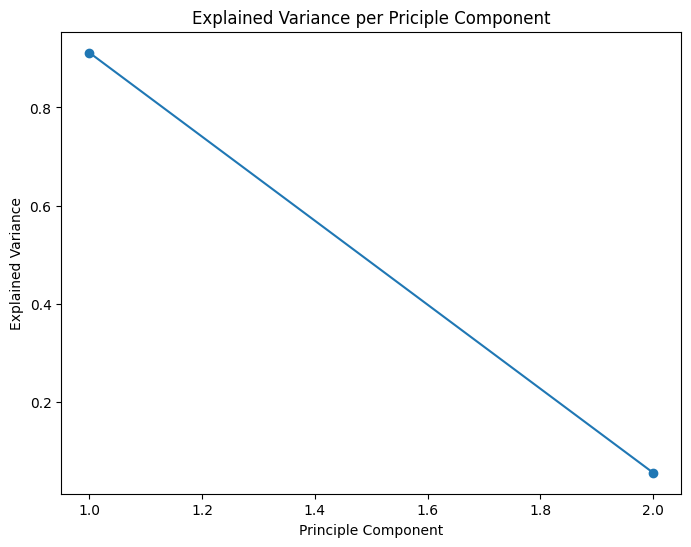

In [45]:
pca = PCA(n_components=2) # the elbow method showed 2 PC are best
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance per Priciple Component')
plt.xlabel('Principle Component')
plt.ylabel('Explained Variance')
plt.show()

# Clustering

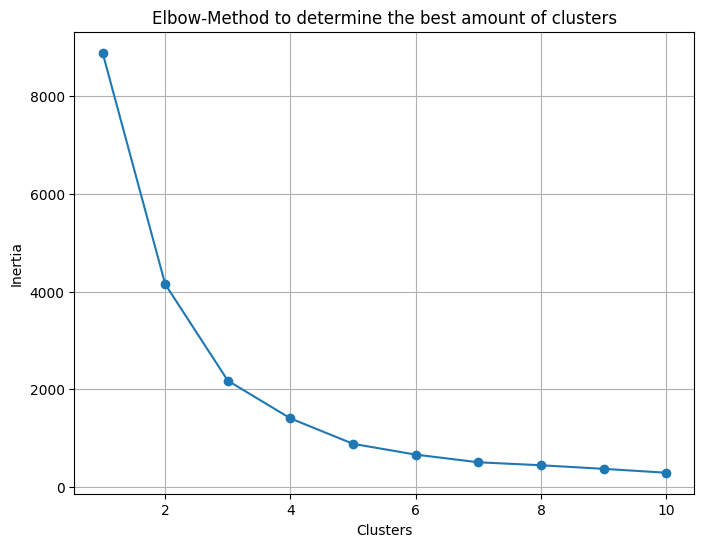

In [46]:
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Elbow-Method to visualize
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow-Method to determine the best amount of clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


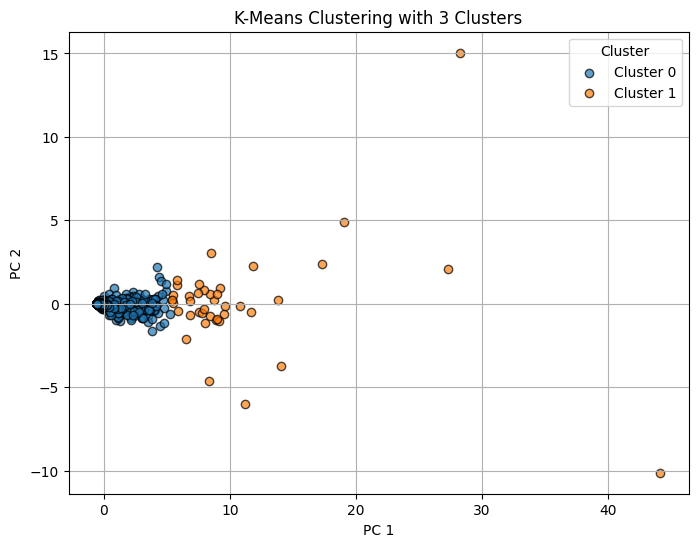

In [67]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)
df_final['cluster'] = clusters

plt.figure(figsize=(8, 6))

for cluster_label in sorted(set(clusters)):
    plt.scatter(
        X_pca[clusters == cluster_label, 0],
        X_pca[clusters == cluster_label, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7,
        edgecolors='k'
    )

plt.title('K-Means Clustering with 3 Clusters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [68]:
# 3d plotting

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
# X_tsne_3d = tsne_3d.fit_transform(X_pca)

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# for cluster_label in sorted(set(clusters)):
#     ax.scatter(
#         X_tsne_3d[clusters == cluster_label, 0],
#         X_tsne_3d[clusters == cluster_label, 1],
#         X_tsne_3d[clusters == cluster_label, 2],
#         label=f'Cluster {cluster_label}',
#         alpha=0.7
#     )

# ax.set_title('3D t-SNE Visualization of Clusters')
# ax.set_xlabel('t-SNE 1')
# ax.set_ylabel('t-SNE 2')
# ax.set_zlabel('t-SNE 3')

# ax.legend(title='Cluster')
# plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


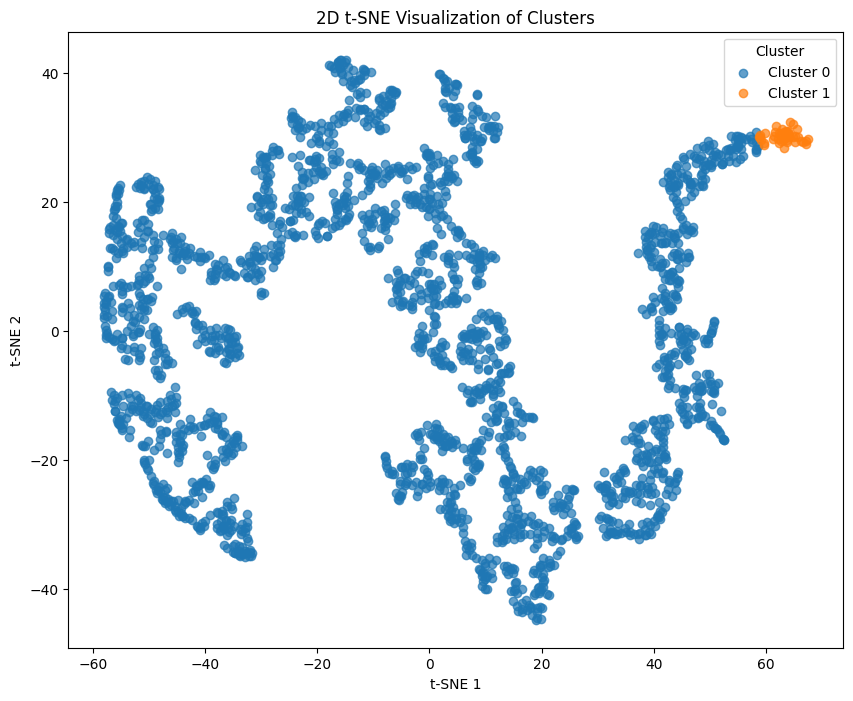

In [69]:
# 2d plotting
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_2d = tsne_2d.fit_transform(X_pca)

plt.figure(figsize=(10, 8))

for cluster_label in sorted(set(clusters)):
    plt.scatter(
        X_tsne_2d[clusters == cluster_label, 0],
        X_tsne_2d[clusters == cluster_label, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7
    )

plt.title('2D t-SNE Visualization of Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.show()


# Interpretation

In [70]:
df_final.head()

,FIPS,ap,est,emp,current_gdp,GDP_growth_rate,cluster
0,10001,2213807,3628,38562,22652836.0,2057.552230,0
1,10003,10918846,14531,155379,243477316.0,2962.917645,0
2,10005,2714312,6078,54175,43727204.0,2344.828798,0
4,11001,36171866,19096,379113,574989171.0,3328.926192,1
5,12001,5690623,8412,100214,64249411.0,3509.105676,0


In [71]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2296 entries, 0 to 2383
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FIPS             2296 non-null   object 
 1   ap               2296 non-null   int64  
 2   est              2296 non-null   int64  
 3   emp              2296 non-null   int64  
 4   current_gdp      2296 non-null   float64
 5   GDP_growth_rate  2296 non-null   float64
 6   cluster          2296 non-null   int32  
dtypes: float64(2), int32(1), int64(3), object(1)
memory usage: 134.5+ KB


In [72]:
cluster_summary = df_final.groupby('cluster')[['ap', 'est', 'emp', 'current_gdp']].mean().reset_index()
print(cluster_summary)

   cluster            ap           est            emp   current_gdp
0        0  1.690673e+06   2011.402217   24831.144124  2.057716e+07
1        1  6.217820e+07  44596.195122  756581.268293  7.259160e+08


1.   Cluster 0: Few employment & low GDP
2.   Cluster 1: Highest employement but no GDP.
3.   Cluster 2: Economic top regions with high employment in important industries.


In [74]:
df_result = df_final[(df_final['cluster']==1)].reset_index(drop=True)
df_result.head()

,FIPS,ap,est,emp,current_gdp,GDP_growth_rate,cluster
0,11001,36171866,19096,379113,574989171.0,3328.926192,1
1,12011,33360825,61298,561836,588080980.0,3532.161925,1
2,12031,25628832,30710,389717,361484160.0,3621.954351,1
3,12057,50443513,48494,729243,522828093.0,3581.524479,1
4,12086,40231204,77696,627675,870680259.0,3615.540231,1


In [75]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FIPS             41 non-null     object 
 1   ap               41 non-null     int64  
 2   est              41 non-null     int64  
 3   emp              41 non-null     int64  
 4   current_gdp      41 non-null     float64
 5   GDP_growth_rate  41 non-null     float64
 6   cluster          41 non-null     int32  
dtypes: float64(2), int32(1), int64(3), object(1)
memory usage: 2.2+ KB


# Visalization

In [76]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Merging GeoData with clusters
gdf_cluster = df_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')
gdf_cluster = gdf_cluster.groupby('FIPS').agg({
    'emp': 'sum',
    'est': 'sum',
    'current_gdp': 'sum'
}).sort_values(['emp',	'est',	'current_gdp'])
gdf_cluster.head()

scaled_values = scaler.fit_transform(gdf_cluster[['emp', 'est', 'current_gdp']])

gdf_cluster['scaled_emp'] = scaled_values[:, 0]
gdf_cluster['scaled_est'] = scaled_values[:, 1]
gdf_cluster['scaled_gdp'] = scaled_values[:, 2]

gdf_cluster['economic_importance'] = (
    gdf_cluster['scaled_emp'] * 0.5 +
    gdf_cluster['scaled_est'] * 0.3 +
    gdf_cluster['scaled_gdp'] * 0.2
)

gdf_cluster = gdf_cluster.sort_values(by='economic_importance', ascending=False)

gdf_cluster.head()

,emp,est,current_gdp,scaled_emp,scaled_est,scaled_gdp,economic_importance
FIPS,,,,,,,
48201,3650948,138201,1.955070e+09,1.000000,1.000000,0.492086,0.898417
17031,1762009,112787,1.998678e+09,0.438416,0.788180,0.504010,0.556464
36061,1288103,68448,3.812610e+09,0.297523,0.418623,1.000000,0.474349
53033,1008761,78781,1.798052e+09,0.214474,0.504747,0.449152,0.348492
48113,1149720,64307,1.449368e+09,0.256382,0.384109,0.353810,0.314185


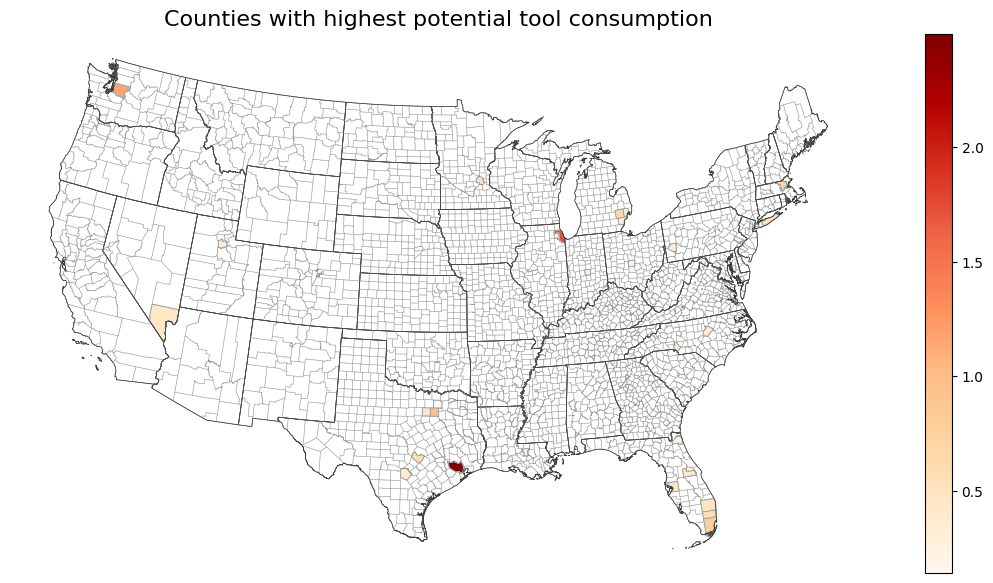

In [77]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]
filtered_statefps = filtered_states['STATEFP'].unique()
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')

scaler = MinMaxScaler()
gdf_cluster['economic_importance'] = scaler.fit_transform(
    gdf_cluster[['emp', 'est', 'current_gdp']]
).sum(axis=1)

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

fig, ax = plt.subplots(figsize=(15, 7))

vmin = gdf_cluster['economic_importance'].min()
vmax = gdf_cluster['economic_importance'].max()

gdf_cluster.plot(
    column='economic_importance',
    cmap='OrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    vmin=vmin,
    vmax=vmax
)

filtered_states.boundary.plot(ax=ax, color='black', linewidth=0.5)
filtered_county.boundary.plot(ax=ax, color='gray', linewidth=0.4, alpha=0.5)

ax.set_title('Counties with highest potential tool consumption', fontsize=16)
ax.set_axis_off()

plt.show()


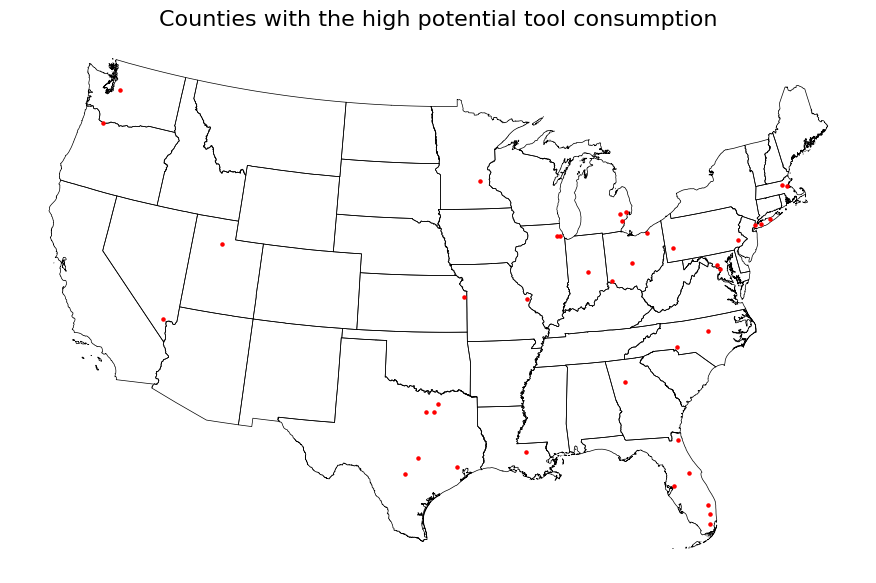

In [78]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

# Exclude some states
non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]

filtered_statefps = filtered_states['STATEFP'].unique()

filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

gdf_cluster['centroid'] = gdf_cluster.geometry.centroid

fig, ax = plt.subplots(figsize=(15, 7))

filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

gdf_cluster.set_geometry('centroid').plot(ax=ax, color='red', markersize=5)

ax.set_title('Counties with the high potential tool consumption', fontsize=16)
ax.set_axis_off()

plt.show()

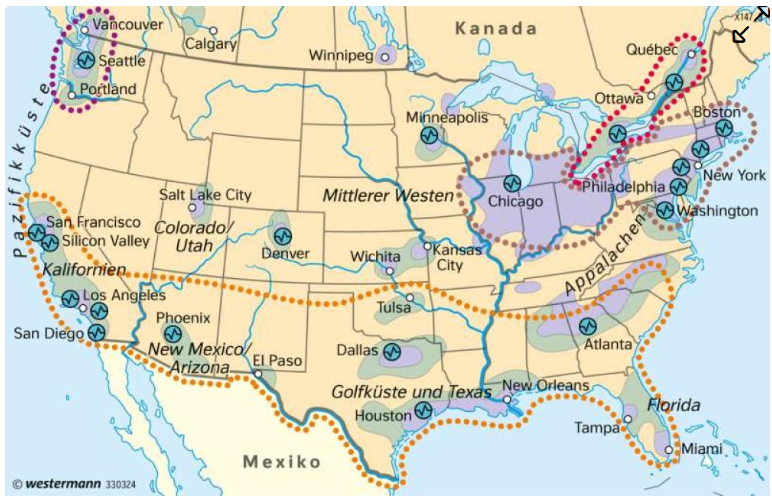

In [58]:
import cv2
from google.colab.patches import cv2_imshow

image_path = '/content/DDM-Project-WS24-25/usa_economic_key_regions.png'
image = cv2.imread(image_path)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

- The Manufacturing Belt around Chicago and Detroit is the largest and oldest industrial region in the U.S., recently impacted by significant structural change.

- The East Coast metropolitan area, from Boston through New York to Washington, is a leading hub for high-tech industries, diverse manufacturing, and major service centers.

- The Portland/Seattle area is known for strong high-tech and aerospace industries, alongside timber processing and paper manufacturing.

- Economic centers in the West include San Francisco and the Silicon Valley (electronics and computer industries) as well as Los Angeles/San Diego (high-tech, heavy and light industries, and services). Together with mining, industrial, high-tech, and service hubs in Phoenix, Dallas, Houston/New Orleans, Atlanta, and Florida, these regions form the Sunbelt, the U.S. economy's growth area.